In [3]:
import math
from collections import Counter

from qiskit import IBMQ, BasicAer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector

from typing import List, Tuple
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit_optimization import QuadraticProgram
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit.circuit.library import GroverOperator, ZGate
from qiskit.algorithms import AmplificationProblem

from qiskit_optimization.translators import from_docplex_mp
from qiskit.circuit.library.arithmetic.adders.draper_qft_adder import DraperQFTAdder
from qiskit.algorithms import Grover
from qiskit import Aer
from qiskit.compiler import transpile, assemble
from math import sqrt


In [ ]:
How do you generate an equal superposition of all permutations of |123>?

First the naive approach, simply construct a circuit of 3 control swap gates, and set the 3 control qubits in a 1/sqrt(2)(|0>+|1>) state.
This is illustrated below, but note that we run into an issue that the superposition is not equal since the states |132> and |231> are produced twice.
---------------------
c-SWAP(0,1) control: q1
c-SWAP(1,2) control: q2
c-SWAP(0,2) control: q3
|q1q2q3> = (|0>+|1>)(|0>+|1>)(|0>+|1>)
Control qubits:
000,    001,     010,    011   , 100,    101, 110, 111
|123>, |321>, |132>, |231>, |213>, |312>, |231>, |132> 
---------------------

The solution is to find another superposition of the control qubits that results in the correct amplitude of each of the final states, we will do this by writing our problem into a system of equations of 3 unknowns and 6 equations.
steps:
1- first write out the state of the control qubits if we started with a generic superposition: |c1>=a|0>+sqrt(1-a^2)|1>, |c2>=b|0>+sqrt(1-b^2)|1>, |c3>=c|0>+sqrt(1-c^2)|1>
abc|000>
ab*sqrt(1-c^2)|001>
a*sqrt(1-b^2)c|010>
a*sqrt(1-b^2)*sqrt(1-c^2)|011>
sqrt(1-a^2)bc|100>
sqrt(1-a^2)b*sqrt(1-c^2)|101>
sqrt(1-a^2)*sqrt(1-b^2)c|110>
sqrt(1-a^2)*sqrt(1-b^2)*sqrt(1-c^2)|111>

2- next: note that from the example we worked out in the doc, certain swapping will have the same effect as others, in our case these are |010>,|111> and |011>,|110>
    so we will group these terms together
3- just write a system of equations to solve for a,b and c
(note 1: how term 010 and term 111 are grouped summed together, just like terms 011 and 110)
(note 2: ideally we would write for wolframalpha that we want each of these terms to be equal to 1/6, unfortunately we hit an error: "too many characters", so i just set them all equal to each other and confirmed that the values of a,b,c provided by wolframalpha give us a norm^2 of 1/6 when plugged into the first term)
norm(abc)^2=
norm(ab*√(1-c^2))^2=
norm(a*√(1-b^2)c)^2+norm(√(1-a^2)*√(1-b^2)*√(1-c^2))^2= 
norm(a*√(1-b^2)*√(1-c^2))^2+norm(√(1-a^2)*√(1-b^2)c)^2=
norm(√(1-a^2)bc)^2=
norm(√(1-a^2)b*√(1-c^2))^2

plug it into wolfram alpha: https://www.wolframalpha.com/input?i=norm%28abc%29%5E2%3D+norm%28ab*%E2%88%9A%281-c%5E2%29%29%5E2%3D+norm%28a*%E2%88%9A%281-b%5E2%29c%29%5E2%2Bnorm%28%E2%88%9A%281-a%5E2%29*%E2%88%9A%281-b%5E2%29*%E2%88%9A%281-c%5E2%29%29%5E2%3D+norm%28a*%E2%88%9A%281-b%5E2%29*%E2%88%9A%281-c%5E2%29%29%5E2%2Bnorm%28%E2%88%9A%281-a%5E2%29*%E2%88%9A%281-b%5E2%29c%29%5E2%3D+norm%28%E2%88%9A%281-a%5E2%29bc%29%5E2%3D+norm%28%E2%88%9A%281-a%5E2%29b*%E2%88%9A%281-c%5E2%29%29%5E2

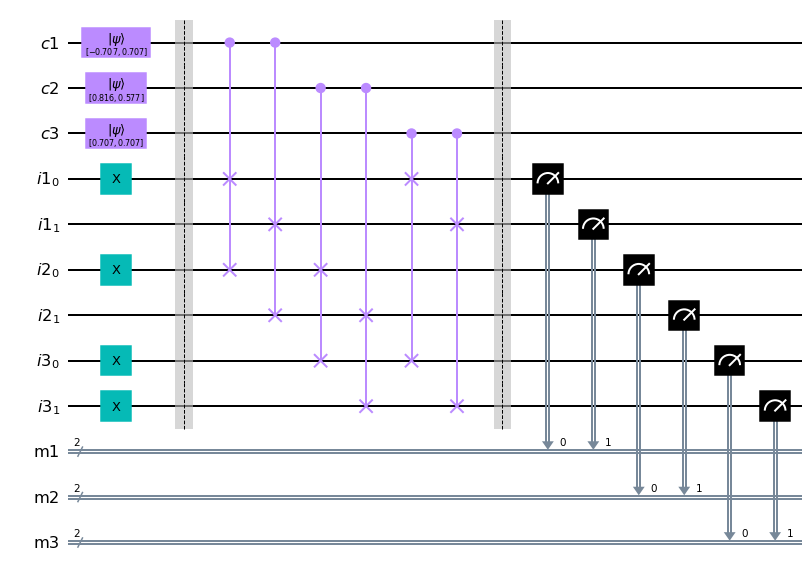

In [56]:
ctrl_qubits = [QuantumRegister(1, "c1"),QuantumRegister(1, "c2"),QuantumRegister(1, "c3")]
input_qubits =[QuantumRegister(2, "i1"),QuantumRegister(2, "i2"),QuantumRegister(2, "i3")]
qregs = ctrl_qubits + input_qubits
cregs = [ClassicalRegister(2, "m1"), ClassicalRegister(2, "m2"), ClassicalRegister(2, "m3")]
qc = QuantumCircuit(*qregs, *cregs)
# https://www.wolframalpha.com/input?i=norm%28abc%29%5E2%3D+norm%28ab*%E2%88%9A%281-c%5E2%29%29%5E2%3D+norm%28a*%E2%88%9A%281-b%5E2%29c%29%5E2%2Bnorm%28%E2%88%9A%281-a%5E2%29*%E2%88%9A%281-b%5E2%29*%E2%88%9A%281-c%5E2%29%29%5E2%3D+norm%28a*%E2%88%9A%281-b%5E2%29*%E2%88%9A%281-c%5E2%29%29%5E2%2Bnorm%28%E2%88%9A%281-a%5E2%29*%E2%88%9A%281-b%5E2%29c%29%5E2%3D+norm%28%E2%88%9A%281-a%5E2%29bc%29%5E2%3D+norm%28%E2%88%9A%281-a%5E2%29b*%E2%88%9A%281-c%5E2%29%29%5E2
# first initialize the control qubits
a=-1/sqrt(2)
b=sqrt(2/3)
c=1/sqrt(2)
qc.initialize([a,sqrt(1-a*a)], ctrl_qubits[0])
qc.initialize([b,sqrt(1-b*b)], ctrl_qubits[1])
qc.initialize([c,sqrt(1-c*c)], ctrl_qubits[2])
# next initialize the input qubits with values 1, 2 and 3
qc.x(input_qubits[0][0]) # set 1st value to 1
qc.x(input_qubits[1][0]) # set 2nd value to 2
qc.x(input_qubits[2]) # set 3rd value to 3
qc.barrier()
## now add the control swap gates
# c-swap 1st with 1st and 2nd with 2nd for each register
qc.cswap(ctrl_qubits[0],input_qubits[0][0],input_qubits[1][0])
qc.cswap(ctrl_qubits[0],input_qubits[0][1],input_qubits[1][1])

qc.cswap(ctrl_qubits[1],input_qubits[1][0],input_qubits[2][0])
qc.cswap(ctrl_qubits[1],input_qubits[1][1],input_qubits[2][1])

qc.cswap(ctrl_qubits[2],input_qubits[0][0],input_qubits[2][0])
qc.cswap(ctrl_qubits[2],input_qubits[0][1],input_qubits[2][1])

qc.barrier()
qc.measure(range(3,5),range(0,2))
qc.measure(range(5,7),range(2,4))
qc.measure(range(7,9),range(4,6))

qc.draw('mpl')

[('01 11 01', 21932), ('01 01 11', 21900), ('11 01 01', 21704)]


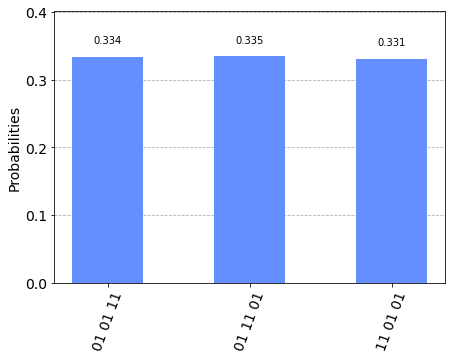

In [57]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 2**16
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()

print(Counter(answer).most_common())
plot_histogram(answer)